In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timefusion import TimeFusion
import random
import torch
from torch import nn


In [2]:
# Create dataset of two correlated, random walks on top of sine functions
# Set random seed to make result reproducible
np.random.seed(0)

# Random walk starts at 0,0
z = np.array([0,0])

# Covariance matrix for normal distribution
cov = [
    [1, 0.5],
    [0.5, 1]
]

# List to hold samples
samples = []

for i in range(30000):

    # Calculate underlying sine values
    y = 1*np.array([np.sin(0.04*i),np.sin((0.06*i + 1))])
    #y = 1*np.array([np.sin(0.04*i),np.sin(0.04*i)])

    # Draw random samples from normal distribution
    #z = np.random.multivariate_normal(z,cov)
    z = np.array([0,0])

    # Store samples
    samples.append(y + z)

# Create pandas DataFrame out of data
data = pd.DataFrame(data=samples,columns=["sine1","sine2"])

# Remove 50% of samples to make into an irregular time-series
keep = 1 # What fraction of cells to keep
mask = [False]*int(2*len(data)*keep) + [True]*int(2*len(data)*(1-keep))
random.shuffle(mask)
mask = np.array(mask).reshape((len(data),2))
data = data.mask(mask)

# Remove all rows without any data
data = data.dropna(axis = 0, how = 'all')


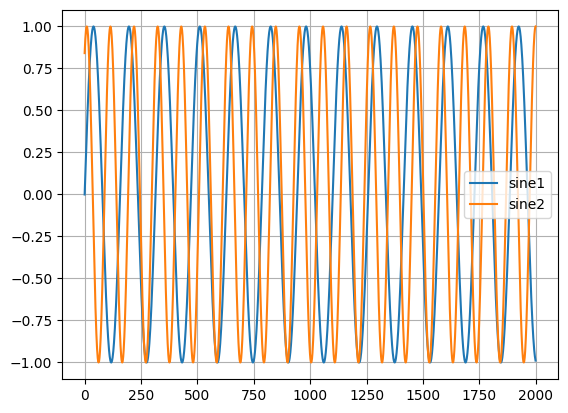

In [3]:
# Plot data so we can inspect it
data[:2000].plot()
plt.grid(True)

In [4]:
predictor = TimeFusion(
    datapoint_dim = 3,
    context_length = 50,
    prediction_length = 10,
    start_length = 10,
    indices = [1,2],
    timestamps = [],
    device = torch.device("mps"),
    diff_steps=100,
    dim_feedforward=256,
    num_decoder_layers=3,
    num_encoder_layers=3,
    nhead=12,
    d_model=768,
)

In [5]:
print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 24409730


In [14]:
predictor.train(
    train_data=data[data.index <= 2900],
    epochs=45,
    val_data=data[data.index > 29000],
    val_metrics= {
        "Val MAE": nn.L1Loss(),
        "Val MSE": nn.MSELoss()
    },
    optimizer=torch.optim.Adam(params=predictor.parameters(),lr=1e-4)
)

In [7]:
from diffusion import BatchLoader
val_loader = BatchLoader(
    device = predictor.device,
    data = data.iloc[-500:], 
    batch_size = 1, 
    context_length = predictor.context_length,
    prediction_length = predictor.prediction_length,
    start_length=predictor.start_length,
    diff_steps = predictor.diff_steps
)

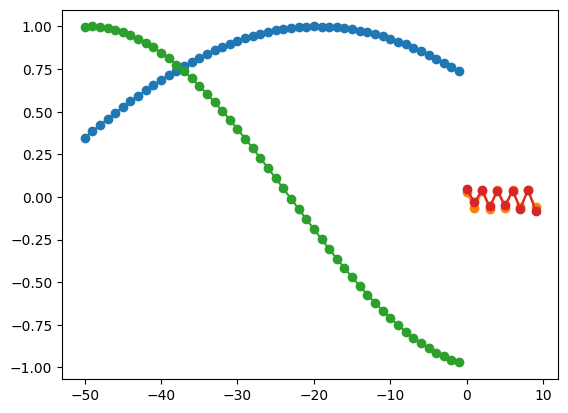

In [8]:

# Plot one example from the validation set
with torch.no_grad():

    for i, batch in enumerate(val_loader, start = 1):
        context, queries, targets = batch
        predictions = predictor(context,queries)
        break
    

plt.plot(context[0,0,:,1].cpu(),context[0,0,:,0].cpu(),"-o")
plt.plot(queries[0,0,predictor.start_length:,1].cpu(),predictions[0,0].cpu(),"-o")
plt.plot(context[0,1,:,1].cpu(),context[0,1,:,0].cpu(),"-o")
plt.plot(queries[0,1,predictor.start_length:,1].cpu(),predictions[0,1].cpu(),"-o")

In [9]:
queries[0,1,:predictor.start_length,1]

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/.venv/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.],
       device='mps:0')

In [10]:
queries[0,0,10:,1]

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], device='mps:0')

In [11]:
context[0,0,:,1]

tensor([-50., -49., -48., -47., -46., -45., -44., -43., -42., -41., -40., -39.,
        -38., -37., -36., -35., -34., -33., -32., -31., -30., -29., -28., -27.,
        -26., -25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
        -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
         -2.,  -1.], device='mps:0')

In [12]:
from diffusion import BatchLoader

%load_ext line_profiler

def f():
    BatchLoader(
        data = data[data.index < 300],
        context_length = 20,
        prediction_length = 20,
        start_length = 10
    )


%lprun -f BatchLoader.__init__ f()

# for i, batch in enumerate(train_loader, start = 1):
#     a,b,c = batch
#     print(a.shape,b.shape,c.shape)

Timer unit: 1e-09 s

Total time: 0.164458 s
File: /Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/TimeFusion/diffusion.py
Function: __init__ at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                               def __init__(
    16                                                   self,
    17                                                   data: pd.DataFrame, 
    18                                                   context_length: int,
    19                                                   prediction_length: int,
    20                                                   start_length: int = 0,
    21                                                   batch_size: int = 64, 
    22                                                   diff_steps: int = 100,
    23                                                   betas: List[float] = None,
    24                                                 

In [13]:
list(pd.Series(range(len(data)))[pd.Series(data.index).between(1000,1008)])

[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008]